DIMENSIONALITY REDUCTION

In [2]:
import numpy as np
import os 

#make notebook stable across runs
np.random.seed(42)

#plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#save few of the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

PCA

In [3]:
#BUILD A SIMPLE 3D DATASET
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

Principal components

In [4]:
#use NumPy’s svd() function to obtain all the principal components of the training set, then extract the first two PCs

X_centered = X- X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]


In [5]:
m, n = X.shape
S  = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)


In [6]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

Skipping the projection code to d dimensions and opting to use PCA which takes care of mean centering itself: 

In [15]:
from sklearn.decomposition import PCA 

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [16]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

Explained Variance Ratio

In [21]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)  # Specify the number of principal components
pca.fit(X)  # Fit the PCA model to your data

# Now you can access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

[0.84248607 0.14631839]


84.2% of the dataset’s variance lies along the first axis, and 14.6%
lies along the second axis. The thirs can be ignored as it only has less 1.2% (little info) 

In [22]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Choosing the Right Number of Dimensions
    -: it is generally preferable to choose the number of dimensions that add up to a sufficiently
large portion of the variance (e.g., 95%). Unless you are reducing dimensionality for data visualization—in that case you will generally want to reduce the dimensionality down to 2 or 3

In [24]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False, parser="auto")
mnist.target = mnist.target.astype(np.uint8)

In [25]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [27]:
d

154

Saving figure explained_variance_plot


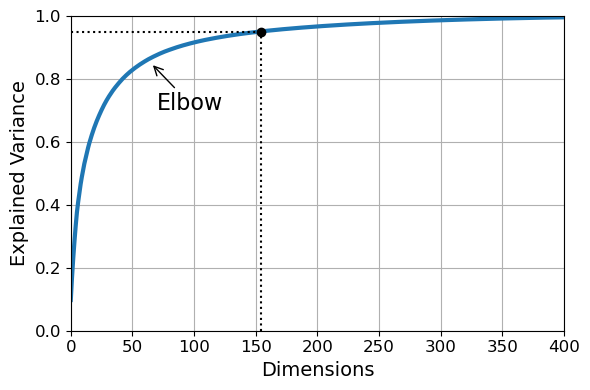

In [28]:
#plot the explained variance as a function of the number of dimensions  
plt.figure(figsize =(6,4))
plt.plot(cumsum, linewidth = 3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy = (65, 0.85), xytext = (70, 0.7),arrowprops = dict(arrowstyle = "->"), fontsize = 16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

the elbow is where the explained variance stops growing fast, thought to be the intrinsic dimensionality of the dataset.

In [30]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)  #much easier alternative code to the above code

In [31]:
pca.n_components_

154

In [33]:
np.sum(pca.explained_variance_ratio_)

0.9504127888294236

PCA for Compression

the following code compresses the MNIST dataset down to 154 dimensions, then uses
the inverse_transform() method to decompress it back to 784 dimensions.

In [34]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Randomize PCA

In [35]:
rnd_pca = PCA(n_components = 154, svd_solver = 'randomized')

X_reduced = rnd_pca.fit_transform(X_train)              

Incremental PCA

you can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new instances arrive)

In [36]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components = 154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)


#Note that you must call the partial_fit() method with each mini-batch rather than the fit() method with the whole training set

In [37]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

In [38]:
X_reduced_inc_pca = X_reduced


In [39]:
#compare the results of transforming MNIST using regular PCA and incremental PCA
#check if mean is the same for both
np.allclose(pca.mean_, inc_pca.mean_)

True

Kernel PCA

 It's good at preserving clusters of instances after projection, or
sometimes even unrolling datasets that lie close to a twisted manifold

In [43]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.04)

#check teextbook for diagrams of kernel PCA

Selecting a Kernel and Tuning Hyperparameters

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"],
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)